<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mohammad Mohammad Beigi
### Student ID: 99102189

# Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 87304130.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34103517.41it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42405887.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6902365.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

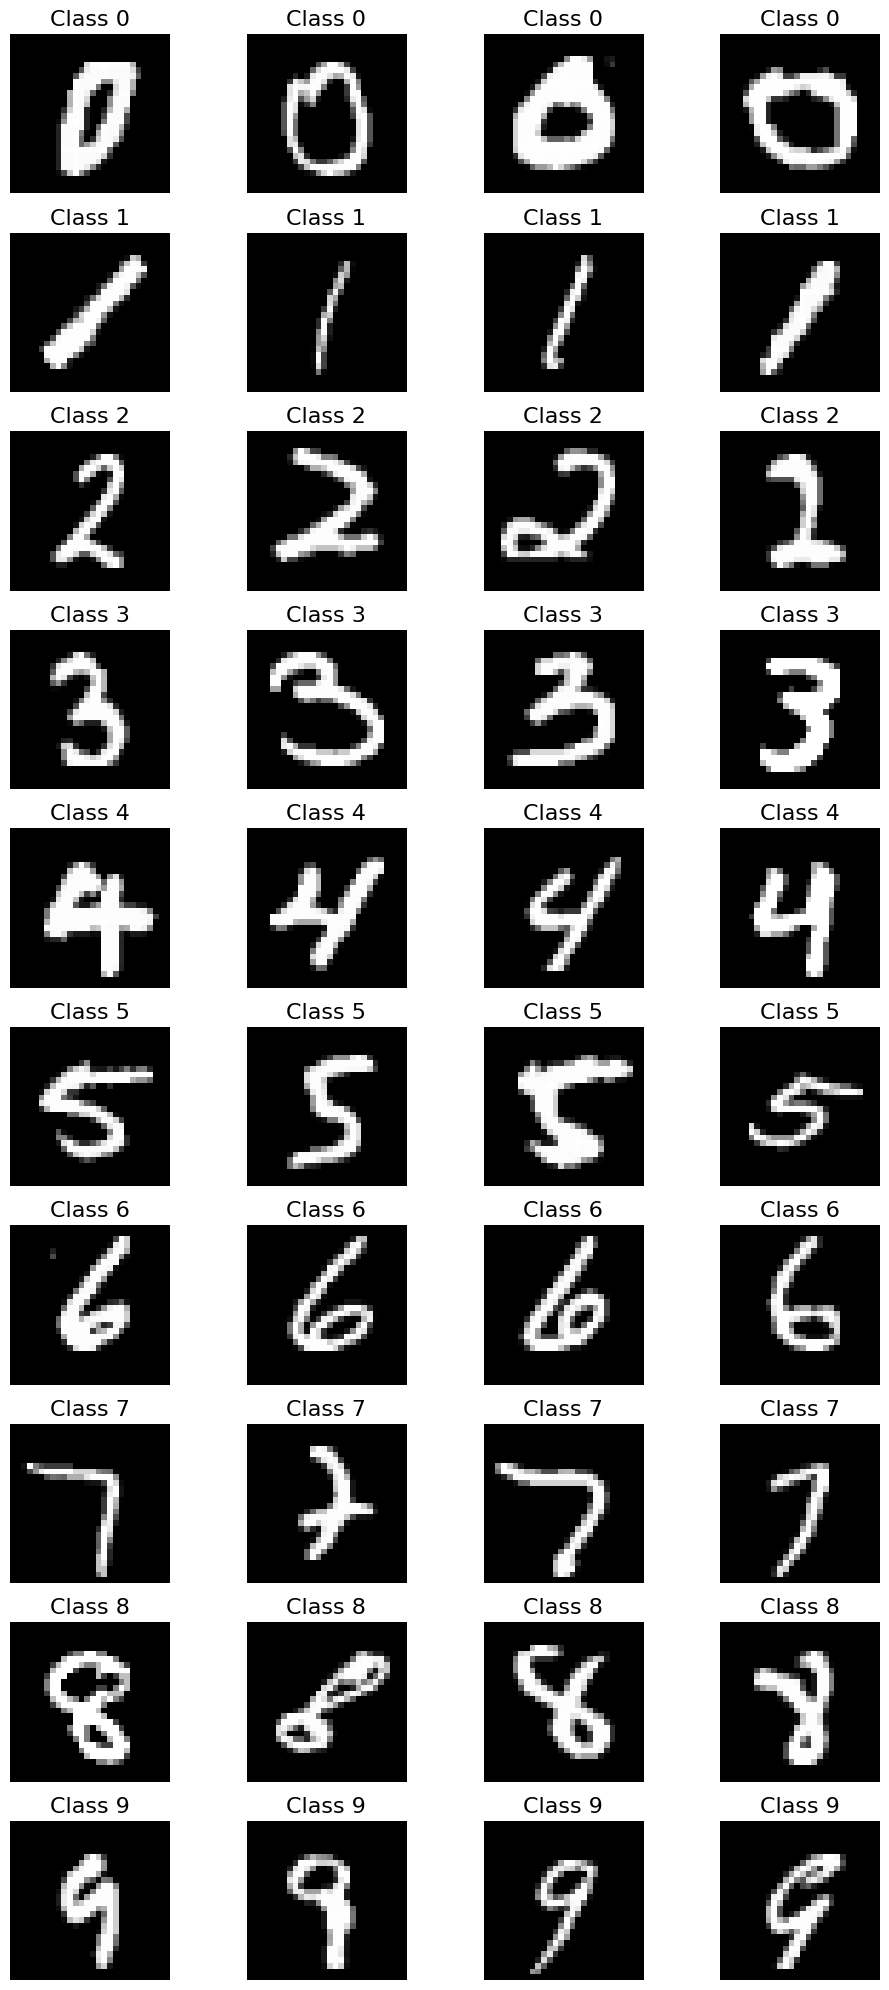

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [6]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar


In [7]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    # Typically, the binary cross entropy loss is used for binary data
    # or mean squared error for continuous data. Here, we assume binary data.
    # recon_x is the reconstructed data, x is the original data
    reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    # This part of the loss encourages the latent space to approximate a normal distribution
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return reconstruction_loss + kl_divergence


In [8]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process
            data = data.view(data.size(0), -1)  # Flatten the data
            recon, mu, logvar = model(data)

            # Calculate the loss
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Number of random samples
                z = torch.randn(num_samples, model.latent_dim)
                sample = model.decoder(z).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i].numpy(), cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 157.13274201253256
Sample Images:


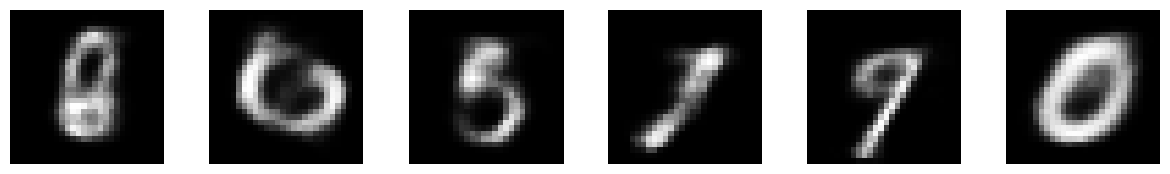


##################################################
VAE-MLP Epoch [2/10], Loss: 121.00448887939453
Sample Images:


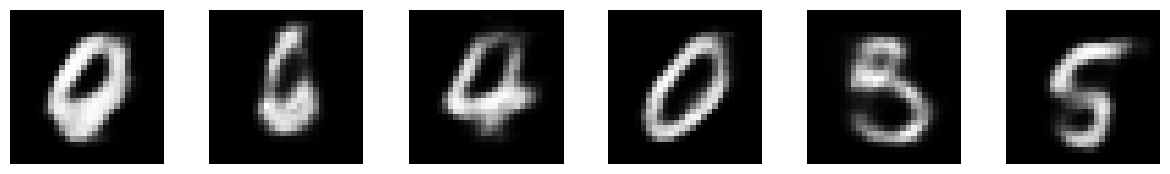


##################################################
VAE-MLP Epoch [3/10], Loss: 113.28275706380208
Sample Images:


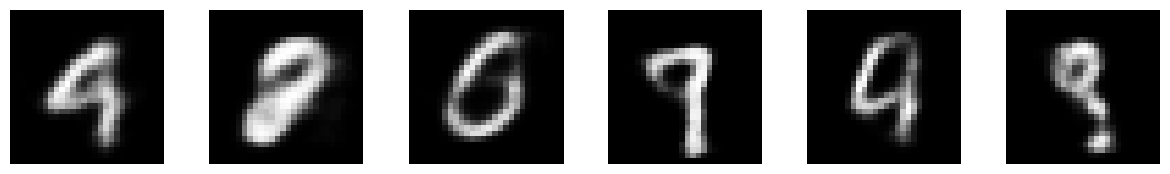


##################################################
VAE-MLP Epoch [4/10], Loss: 109.8775104654948
Sample Images:


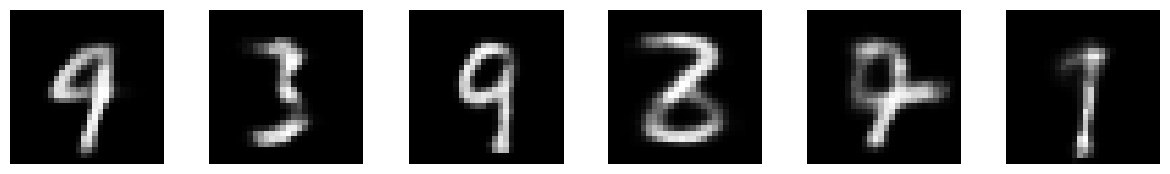


##################################################
VAE-MLP Epoch [5/10], Loss: 107.82498739420573
Sample Images:


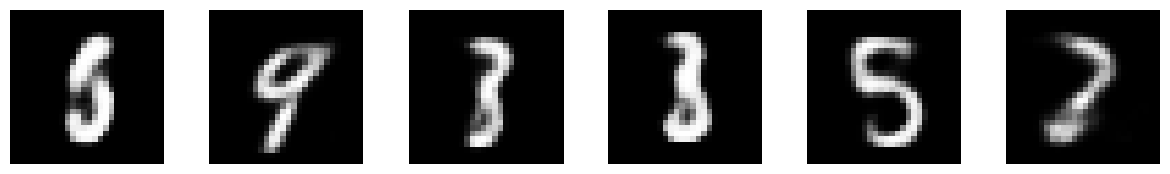


##################################################
VAE-MLP Epoch [6/10], Loss: 106.16873092447916
Sample Images:


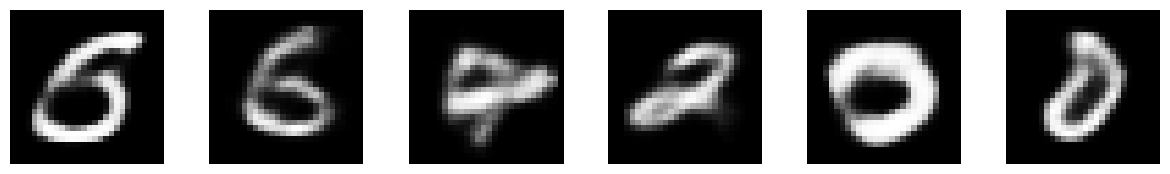


##################################################
VAE-MLP Epoch [7/10], Loss: 104.91650861816406
Sample Images:


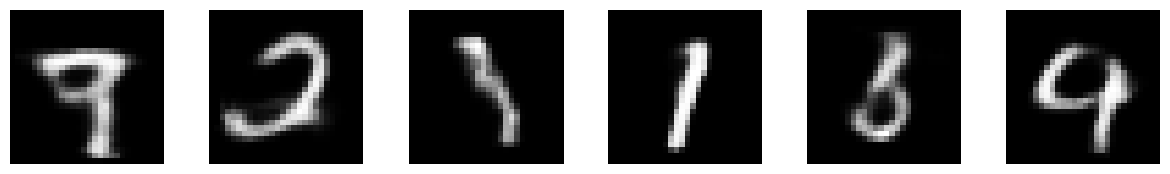


##################################################
VAE-MLP Epoch [8/10], Loss: 104.00287095540365
Sample Images:


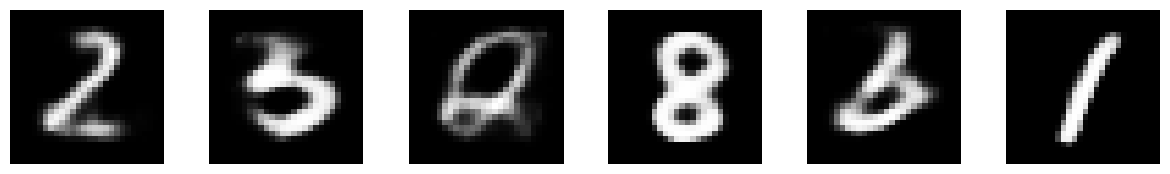


##################################################
VAE-MLP Epoch [9/10], Loss: 103.30438934733073
Sample Images:


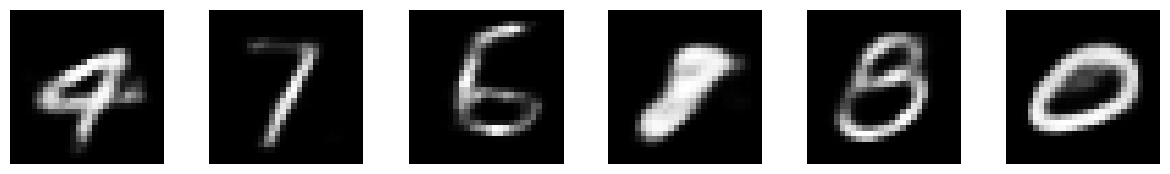


##################################################
VAE-MLP Epoch [10/10], Loss: 102.7415991780599
Sample Images:


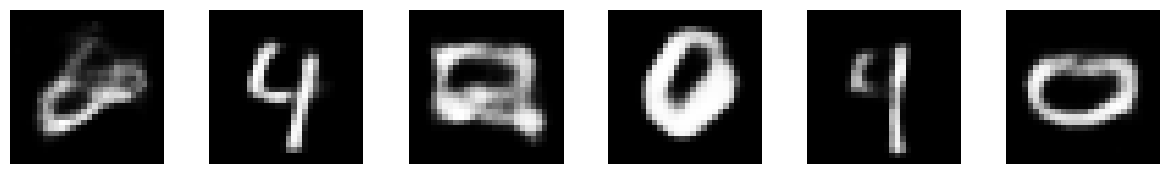

Best model saved as 'best_vae_mlp_model.pth'


In [9]:
# Assuming input_dim, hidden_dim, and latent_dim are already defined,
# otherwise, you need to define them based on your data and model requirements

input_dim = 784  # For MNIST, this is 28x28. Modify accordingly for your dataset.
hidden_dim = 400  # Example hidden dimension size
latent_dim = 20   # Size of the latent space

# Initialize the VAE-MLP model
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)

# Assuming train_loader is defined and properly set up to load your training data
train_vae_mlp(vae_mlp, train_loader)


# 2) CVAE --> MLP

In [10]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)

        # Check if y is already one-hot encoded
        if y.shape[1] != self.num_classes:
            y_one_hot = F.one_hot(y, num_classes=self.num_classes).float()
        else:
            y_one_hot = y.float()

        # Concatenate x and y
        x = torch.cat((x, y_one_hot), dim=1)


        # Encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        class_logits = self.fc_class(hidden)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        z = torch.cat((z, y_one_hot), dim=1)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar, class_logits
    def sample_from_latent_space(self,x, num_samples=1, class_label=None):
        # Generate random samples from the latent space
        with torch.no_grad():
            z = torch.randn(num_samples, latent_dim).to(x.device)
            if class_label is not None:
                class_label = torch.tensor(class_label).to(x.device)
                zy = torch.cat((z, class_label), dim=1)
            else:
                zy = z
            generated_samples = self.decoder(zy)
        return generated_samples


In [11]:
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(data.size(0), -1)

    # Reconstruction loss
    # You can use binary cross-entropy (BCE) for binary data, or mean squared error (MSE) for continuous data
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # Total loss
    return reconstruction_loss + kl_divergence + ce_loss


In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        print("\n" + 50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Ensure labels are in long format for one-hot encoding
            labels = labels.long()
            labels_one_hot = F.one_hot(labels, num_classes=model.num_classes).float()

            # Forward pass: Pass both data and labels to the model
            recon, mu, logvar, class_logits = model(data, labels_one_hot)  # Make sure both data and labels are passed

            # Calculate loss
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)


            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Sample images
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Adjust this according to your dataset
                num_samples_per_class = 1
                z = torch.randn(num_classes * num_samples_per_class, model.latent_dim)
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")

# Example of how to call the training function
# Make sure to define `model` and `train_loader` appropriately
# train_cvae_mlp(model, train_loader)



##################################################
CVAE-MLP Epoch [1/10], Loss: 150.86968864339192
Sample Images:


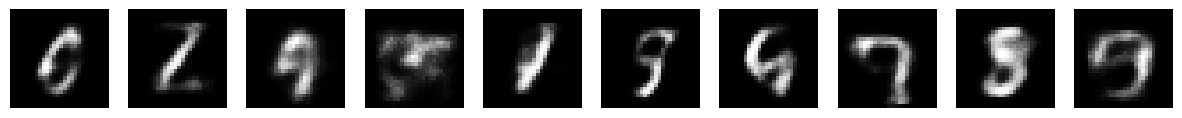


##################################################
CVAE-MLP Epoch [2/10], Loss: 115.82562631835937
Sample Images:


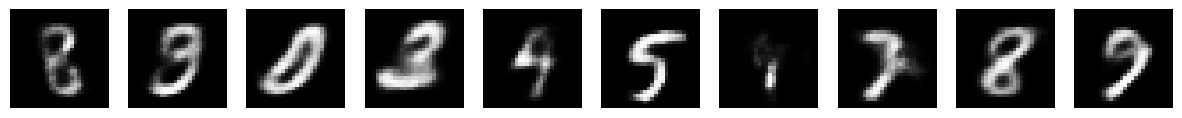


##################################################
CVAE-MLP Epoch [3/10], Loss: 109.11108083902995
Sample Images:


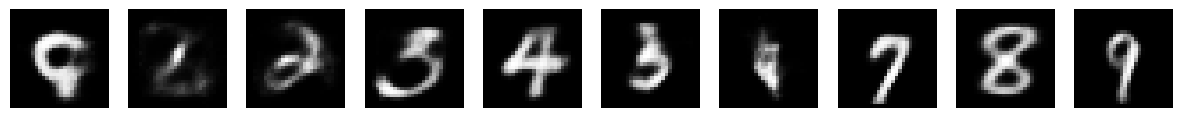


##################################################
CVAE-MLP Epoch [4/10], Loss: 105.59767205403647
Sample Images:


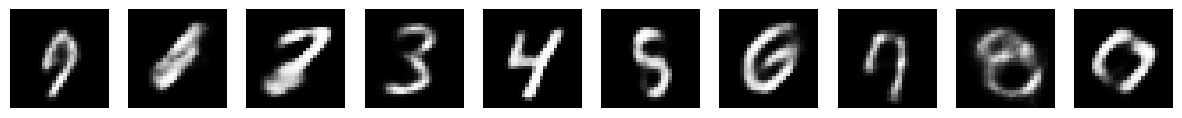


##################################################
CVAE-MLP Epoch [5/10], Loss: 103.39261379801432
Sample Images:


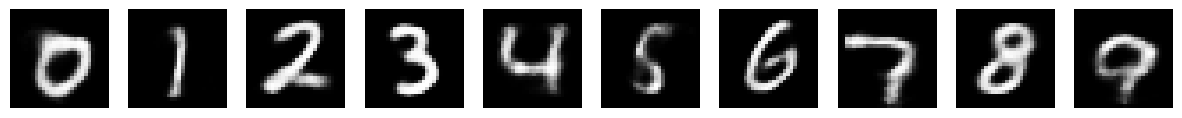


##################################################
CVAE-MLP Epoch [6/10], Loss: 101.90500972086589
Sample Images:


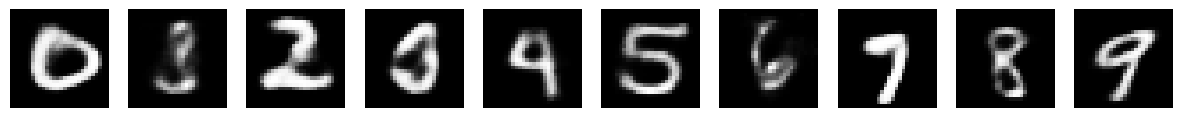


##################################################
CVAE-MLP Epoch [7/10], Loss: 100.60946291097005
Sample Images:


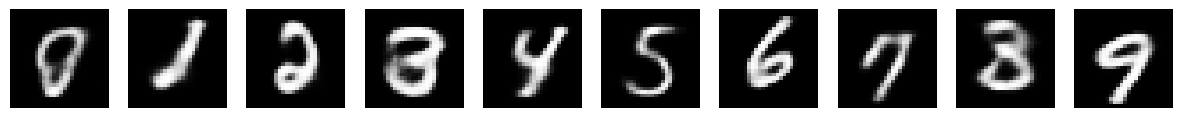


##################################################
CVAE-MLP Epoch [8/10], Loss: 99.64316885172526
Sample Images:


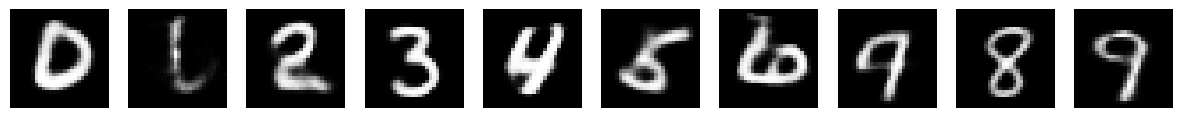


##################################################
CVAE-MLP Epoch [9/10], Loss: 98.9398702758789
Sample Images:


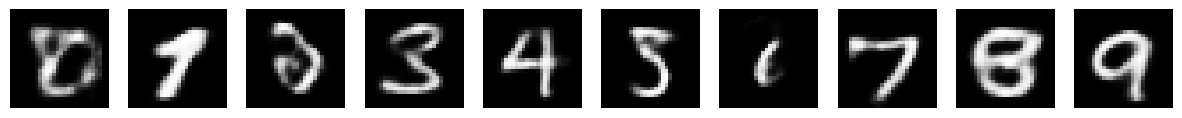


##################################################
CVAE-MLP Epoch [10/10], Loss: 98.30120591227214
Sample Images:


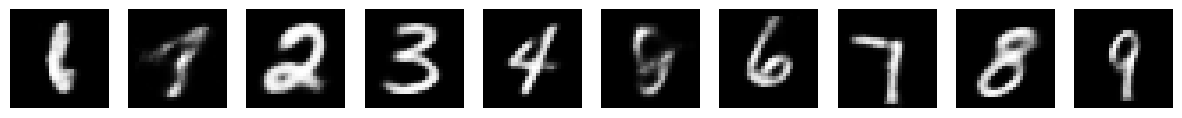

Best model saved as 'best_cvae_mlp_model.pth'


In [13]:
# Initialize the CVAE_MLP model
input_dim = 784  # This should be the size of your flattened input data. For MNIST, it's 28x28.
hidden_dim = 400  # Example hidden dimension size
latent_dim = 20   # Size of the latent space
num_classes = 10  # Set this based on your dataset (e.g., 10 for MNIST)

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)
train_cvae_mlp(cvae_mlp, train_loader)  # Make sure this is the correct function name


# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


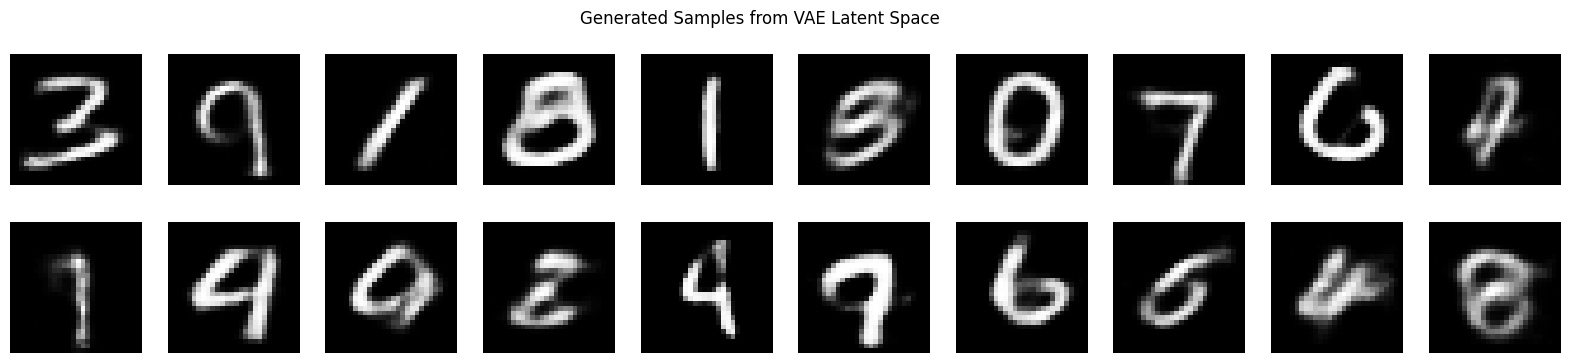

<ipython-input-10-aab70b87f5b0>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_label = torch.tensor(class_label).to(x.device)


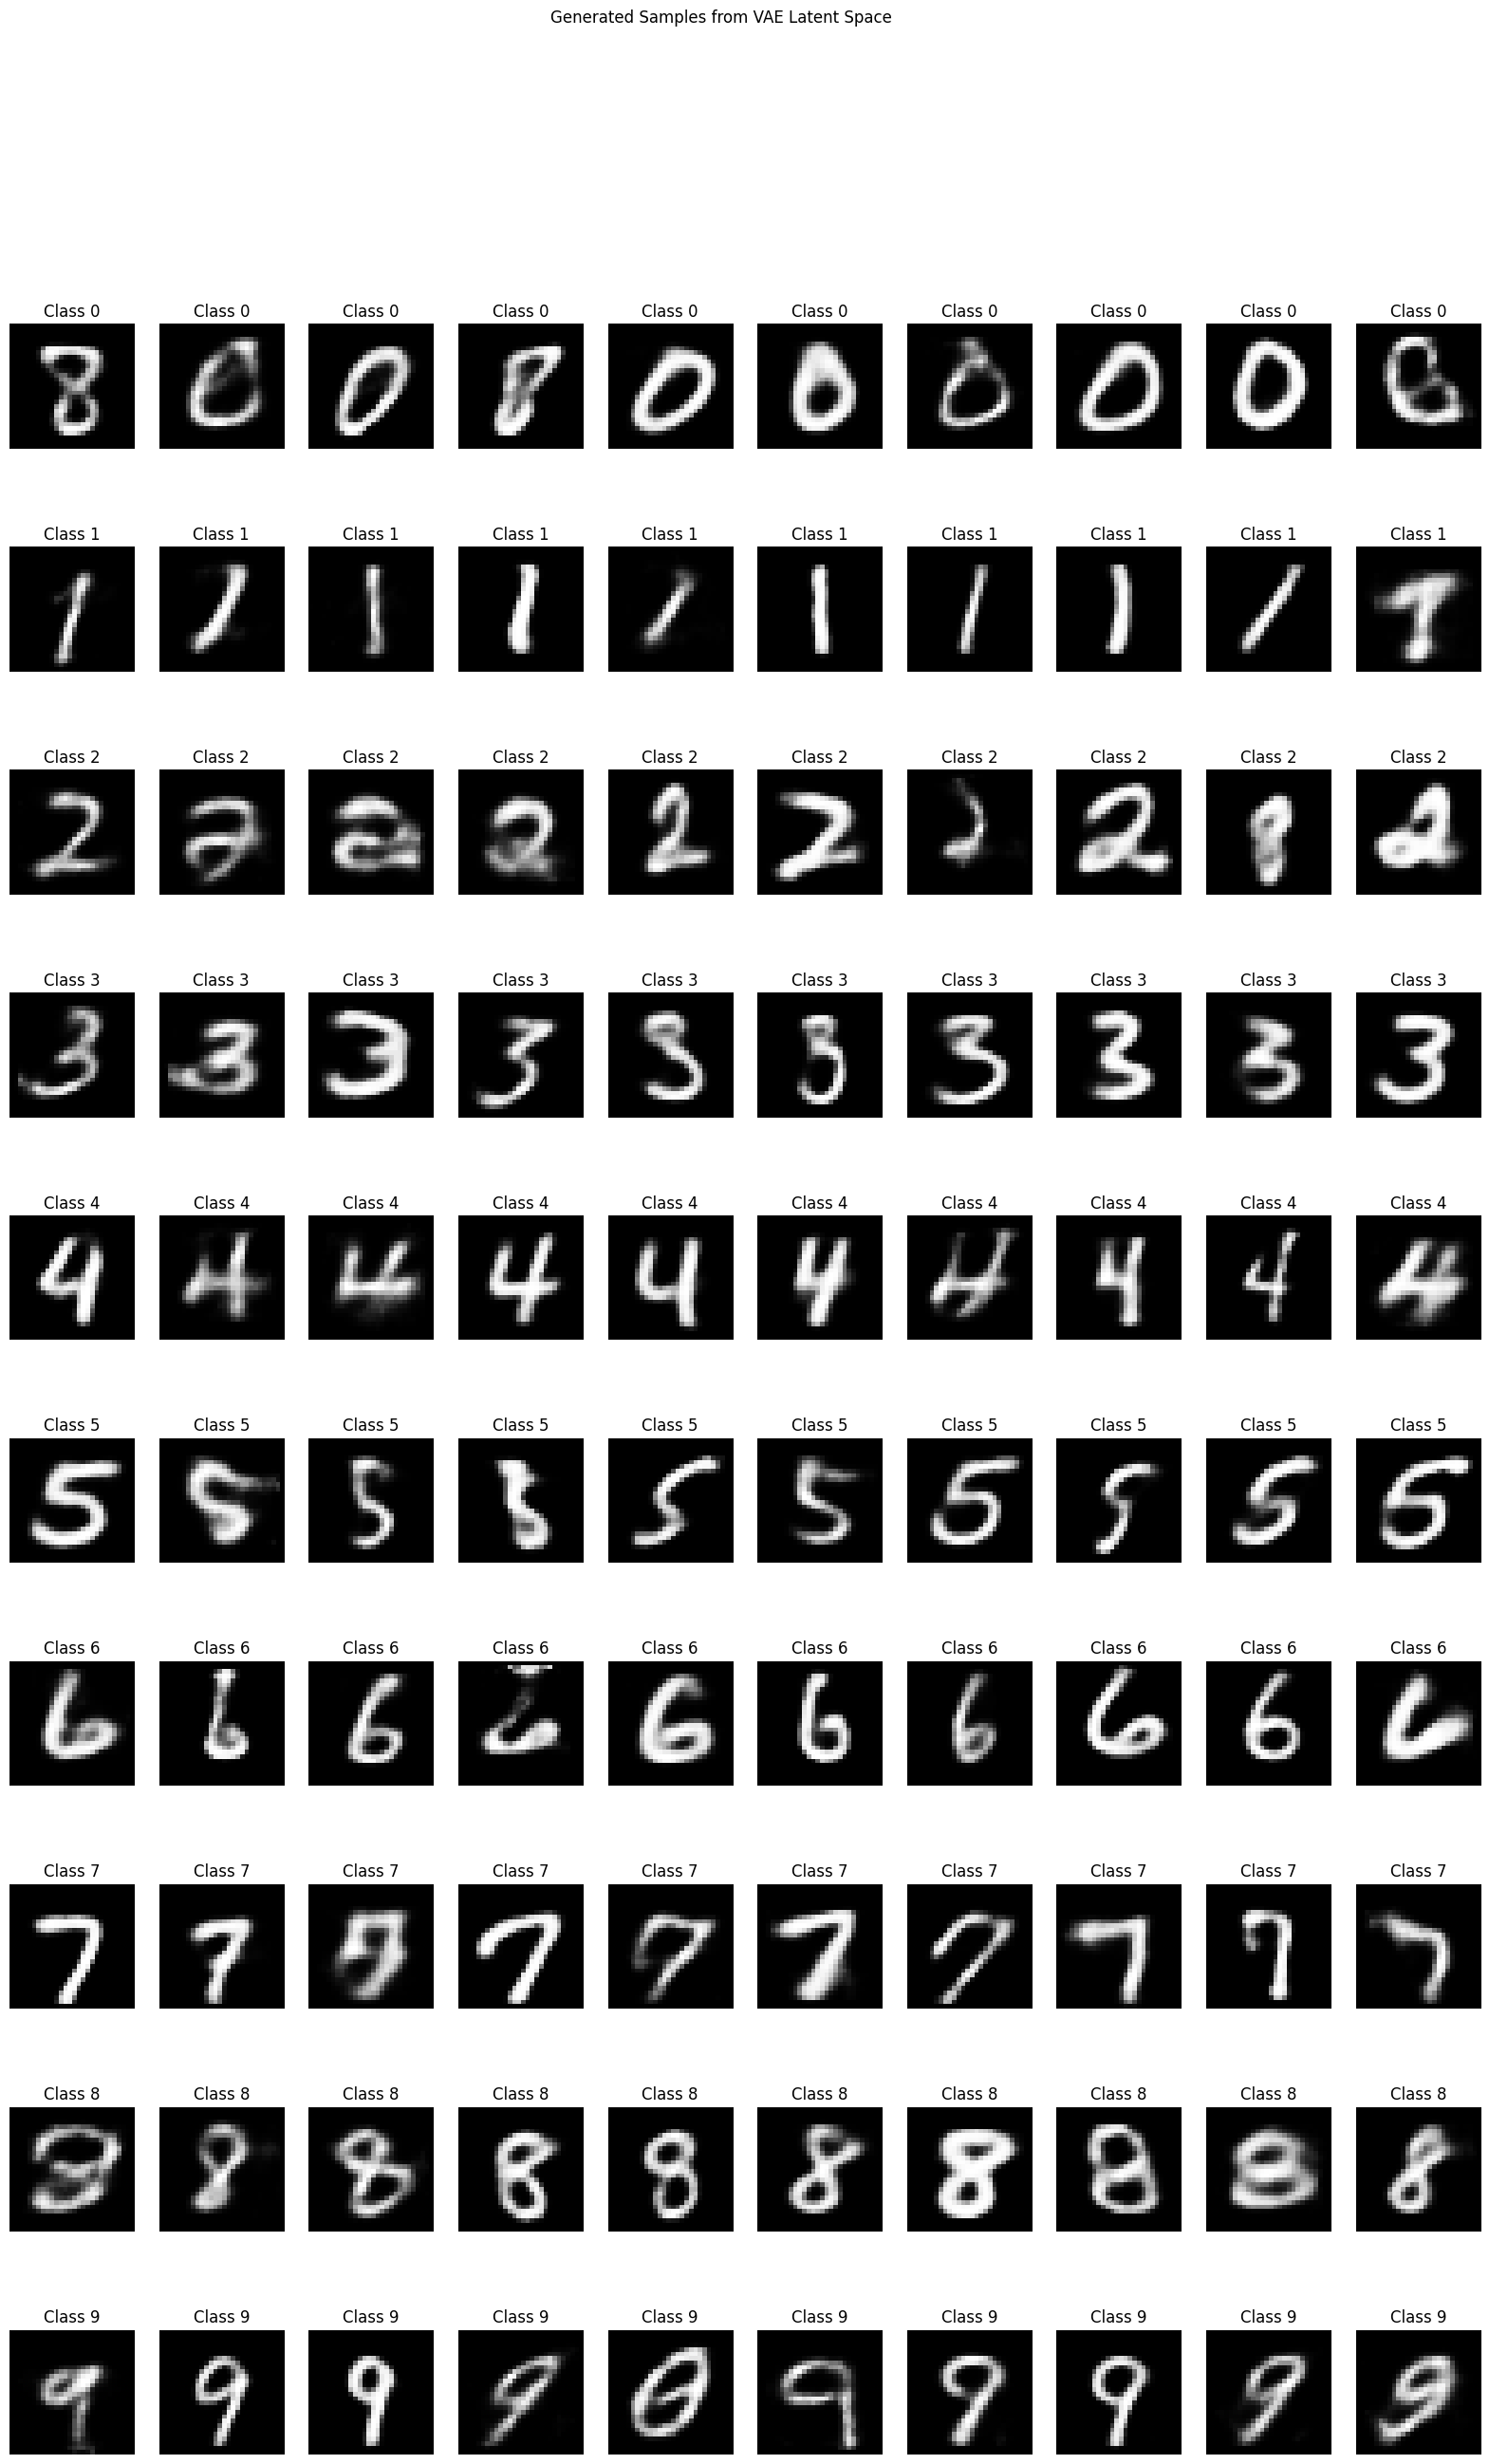

In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define a function to generate random samples from the latent space
def generate_samples(model, num_samples, input_dim, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the entire model to the specified device

    x = torch.randn(num_samples, input_dim).to(device)  # Move x to the specified device
    generated_samples = sample_from_latent_space(model, x, num_samples)  # Call the external function

    return generated_samples

# Define a function to sample from the latent space
def sample_from_latent_space(model, x, num_samples=1, class_label=None):
    # Generate random samples from the latent space
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(x.device)
        if class_label is not None:
            class_label = torch.tensor(class_label).to(x.device)
            zy = torch.cat((z, class_label), dim=1)
        else:
            zy = z
        generated_samples = model.decoder(zy)
    return generated_samples

# Define a function to plot the generated samples
def plot_generated_samples(samples, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))  # num_rows rows, num_cols columns

    for i, sample in enumerate(samples):
        sample = sample.squeeze().detach().cpu().numpy()
        sample = sample.reshape((28, 28))

        row = i // num_cols
        col = i % num_cols

        axes[row, col].imshow(sample, cmap='gray')
        axes[row, col].axis('off')

    # Add title to the entire plot
    plt.suptitle("Generated Samples from VAE Latent Space")
    plt.show()

# Assuming vae_mlp is your VAE model
num_samples = 20
input_dim = 128  # Replace with the actual input dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

generated_samples = generate_samples(vae_mlp, num_samples, input_dim, device)
plot_generated_samples(generated_samples, 2, 10)
import torch
import torch.nn.functional as F  # Ensure you have imported F

def test_generate_samples_with_class(cvae_mlp, num_samples_per_class=10, input_dim=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cvae_mlp.to(device)  # Move the model to the correct device
    fig, axes = plt.subplots(10, num_samples_per_class, figsize=(20, 30))

    for class_label in range(10):
        x = torch.randn(num_samples_per_class, input_dim).to(device)
        class_label_tensor = F.one_hot(torch.tensor([class_label] * num_samples_per_class), num_classes=10).float().to(device)
        generated_samples = cvae_mlp.sample_from_latent_space(x, num_samples_per_class, class_label_tensor)

        for i in range(num_samples_per_class):
            sample = generated_samples[i].squeeze().detach().cpu().numpy()
            sample = sample.reshape((28, 28))

            axes[class_label, i].imshow(sample, cmap='gray')
            axes[class_label, i].axis('off')
            axes[class_label, i].set_title(f"Class {class_label}")

    plt.suptitle("Generated Samples from VAE Latent Space")
    plt.show()

# Assuming cvae_mlp is your Conditional VAE model
cvae_mlp.eval()  # Set the model to evaluation mode
test_generate_samples_with_class(cvae_mlp)


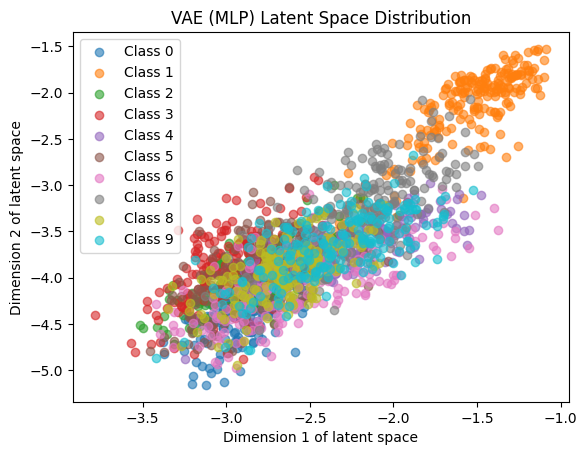

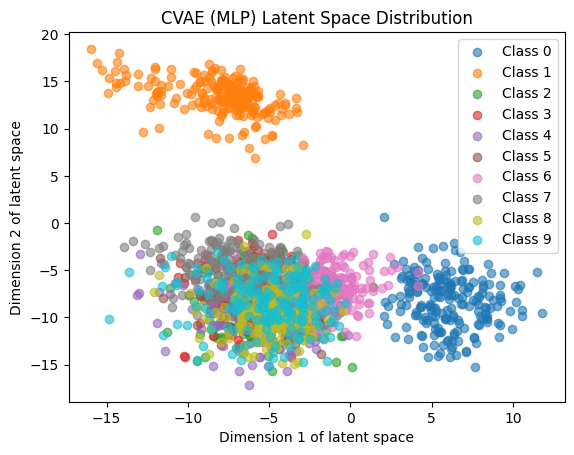

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define a function to plot the latent space representations with different colors for each class
def plot_latent_space_with_classes(x, y, title):
    plt.figure()
    classes = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))
    for i, c in zip(classes, colors):
        plt.scatter(x[y == i, 0], x[y == i, 1], alpha=0.6, c=[c], label=f'Class {i}')
    plt.xlabel('Dimension 1 of latent space')
    plt.ylabel('Dimension 2 of latent space')
    plt.title(title)
    plt.legend()
    plt.show()

# Set the model to evaluation mode
vae_mlp.eval()

# Extract the latent space representations and their corresponding labels for VAE
x_vae = []
y_vae = []
for index, (data, labels) in enumerate(train_loader):
    data = vae_mlp(data.view(data.shape[0], -1).to('cuda'))[-1]  # Move input data to the same device as the model
    if index == 0:
        x_vae = data
        y_vae = labels
    elif index == 30:
        break
    else:
        x_vae = torch.cat([x_vae, data])
        y_vae = torch.cat([y_vae, labels])
x_vae = x_vae.detach().cpu().numpy()  # Move data back to CPU before converting to numpy
y_vae = y_vae.numpy()
plot_latent_space_with_classes(x_vae, y_vae, 'VAE (MLP) Latent Space Distribution')

# Set the model to evaluation mode
cvae_mlp.eval()

# Extract the latent space representations and their corresponding labels for CVAE
x_cvae = []
y_cvae = []
for index, (data, labels) in enumerate(train_loader):
    labels_one_hot = torch.eye(10)[labels].to('cuda')  # Move labels to the same device as the model
    data = cvae_mlp(data.to('cuda'), labels_one_hot)[-1]  # Move input data to the same device as the model
    if index == 0:
        x_cvae = data
        y_cvae = labels
    elif index == 30:
        break
    else:
        x_cvae = torch.cat([x_cvae, data])
        y_cvae = torch.cat([y_cvae, labels])
x_cvae = x_cvae.detach().cpu().numpy()  # Move data back to CPU before converting to numpy
y_cvae = y_cvae.numpy()
plot_latent_space_with_classes(x_cvae, y_cvae, 'CVAE (MLP) Latent Space Distribution')

In a Variational Autoencoder (VAE), the latent space distribution is typically assumed to follow a standard normal distribution, which means that the encoder of the VAE learns to map the input data into the parameters of a normal distribution, usually the mean and the variance. This allows the VAE to generate new data points by sampling from this learned distribution.

On the other hand, in a Conditional Variational Autoencoder (CVAE), the latent space distribution is conditioned on additional information, such as class labels or other attributes relevant to the data. This means that the encoder not only learns to map the input data into the parameters of the distribution (mean and variance), but it also takes into account the conditioning information when generating the latent representation.

This conditioning of the latent space in CVAE allows for more controlled and structured generation of data, as the model can generate samples conditioned on specific attributes or classes. This is particularly useful in tasks such as image generation, where one might want to generate images of a particular class or with specific attributes.

In summary, the main difference in the latent space distribution between VAE and CVAE lies in the conditioning of the distribution on additional information in the case of CVAE, which allows for more structured and controlled generation of data.


Here
to compare two models, we observed that the performance and convergence of the CVAE model is better and it has a lower final loss value. In comparing the explanation of the latent space of the two models based on 1920 data samples given to each model and plotting the two-dimensional distribution of z for each model, it is observed that apparently the latent distribution for VAE has multiple modes in the x, y plane and its distribution is similar to mixture distributions. The data of each class is mapped to a specific part of the two-dimensional space.

However, in the distribution of CVAE, such a thing is not observed and its distribution is like a multivariate normal distribution. It can also be inferred that dimension 1 and dimension 2 of the latent space in this distribution are uncorrelated with each other.